In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
import keras
import seaborn as sns
import pandas as pd
import sys, time
import numpy as np
import warnings


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from math import sqrt


warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))

INFO:tensorflow:Using local port 20174
INFO:tensorflow:Using local port 21325
INFO:tensorflow:Using local port 17798
INFO:tensorflow:Using local port 18841
INFO:tensorflow:Using local port 23852
INFO:tensorflow:Using local port 24177
INFO:tensorflow:Using local port 19969
INFO:tensorflow:Using local port 15158
INFO:tensorflow:Using local port 17149
INFO:tensorflow:Using local port 15258
python 3.7.3 (default, Jul 25 2020, 13:03:44) 
[GCC 8.3.0]
keras version 2.4.3
tensorflow version 2.4.0-dev20201012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  app.launch_new_instance()


In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 0.9))
	scaler = scaler.fit(train)
	print(scaler.data_min_)
	print(scaler.data_max_)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	print(X.shape)
	model = tf.keras.models.Sequential([
		#tf.keras.layers.Input(shape=(1,1), name='input'),
		tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=False),
		#tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(1,name='output')
	])
	model.compile(loss='mean_squared_error', optimizer='adam')
#	model.compile(optimizer='adam',
#                  loss='sparse_categorical_crossentropy',
#                  metrics=['accuracy'])
	model.summary()
	#for i in range(nb_epoch):
	#	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	#	model.reset_states()
	model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
     return ((np.fabs(y_true - y_pred)/y_true).mean())

In [4]:
dataframe = read_csv('dataset.csv', usecols=[1,2,7], engine='python')

In [5]:
dataset = dataframe.values

In [6]:
dataset = dataset.astype('float32')
where_are_NaNs = np.isnan(dataset)
dataset[where_are_NaNs] = 0

In [7]:
newdataset1 = []
newdataset2 = []

for i in range(len(dataset)):
    if dataset[i,1]==39:
        a = dataset[i, 2]
        b = (dataset[i, 0]-1383260400000)/3600000
        newdataset1.append(a)
        newdataset2.append(b)

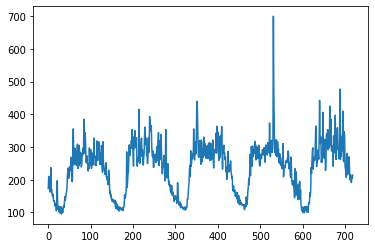

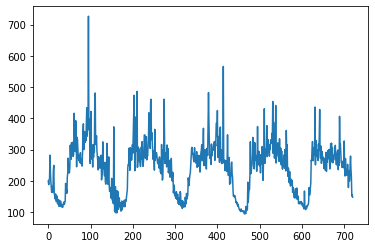

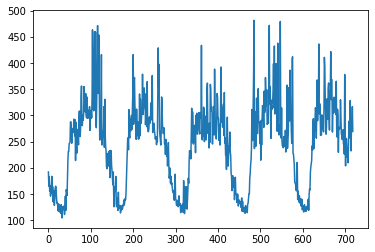

In [8]:
raw_values = np.asarray(newdataset1)
l=len(raw_values)
plt.plot(raw_values[:int(l/3)])
plt.show()
plt.plot(raw_values[int(l/3):-int(l/3)])
plt.show()
plt.plot(raw_values[-int(l/3):])
plt.show()

[-363.16381836 -363.16381836]
[373.3527832 373.3527832]


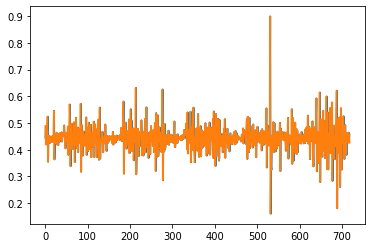

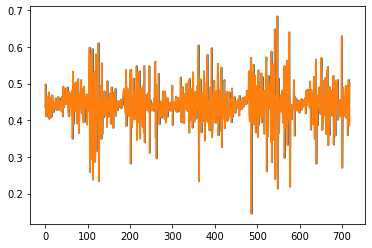

In [10]:
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-int(l/3)], supervised_values[-int(l/3):]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

plt.plot(train_scaled[:int(l/3)])
plt.show()
plt.plot(test_scaled[:int(l/3)])
plt.show()

In [11]:
hunits = 2

In [21]:
file_object =  open('results.csv', 'w')
file_object.write("Hunit; Seuil; Count; Total; Proportion \n")

40

In [22]:
for hunits in range(1,30):

    lstm_model = fit_lstm(train_scaled, 1, 1, hunits)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)

    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        expected = raw_values[len(train) + i + 1]

        predictions.append(yhat)

    for k in range(1,200):
        count = 1
        for i in range(len(test_scaled)):
            if ((np.fabs(predictions[i] - raw_values[len(train) + i + 1])/raw_values[len(train) + i + 1])>(0.005*k)) :
                count+=1
        file_object.write('%d; %.3f; %d; %d; %.2f \n' % (hunits, 0.5*k, ((len(test_scaled)-count)/len(test_scaled)*100), count, len(test_scaled)))

(1439, 1, 1)
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (1, 1)                    12        
_________________________________________________________________
output (Dense)               (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
(1439, 1, 1)
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (1, 2)                    32        
_________________________________________________________________
output (Dense)               (1, 1)                    3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
(1439, 1, 1)

(1439, 1, 1)
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (1, 15)                   1020      
_________________________________________________________________
output (Dense)               (1, 1)                    16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
(1439, 1, 1)
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (1, 16)                   1152      
_________________________________________________________________
output (Dense)               (1, 1)                    17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


(1439, 1, 1)
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (1, 28)                   3360      
_________________________________________________________________
output (Dense)               (1, 1)                    29        
Total params: 3,389
Trainable params: 3,389
Non-trainable params: 0
_________________________________________________________________
(1439, 1, 1)
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (1, 29)                   3596      
_________________________________________________________________
output (Dense)               (1, 1)                    30        
Total params: 3,626
Trainable params: 3,626
Non-trainable params: 0
_________________________________________________________________


In [23]:
file_object.close()

In [101]:
resultats = read_csv('results.csv', usecols=[0,1,2], engine='python', sep =";")

In [102]:
set_resultat = resultats.values

In [103]:
set_resultat = set_resultat.astype('float32')
where_are_NaNs = np.isnan(set_resultat)
set_resultat[where_are_NaNs] = 0

In [104]:
set_resultat

array([[ 1. ,  0.5,  3. ],
       [ 1. ,  1. ,  7. ],
       [ 1. ,  1.5, 10. ],
       ...,
       [29. , 98.5, 99. ],
       [29. , 99. , 99. ],
       [29. , 99.5, 99. ]], dtype=float32)

In [105]:
newdataset1 = []
newdataset2 = []
newdataset3 = []

for i in range(len(set_resultat)):
    a = set_resultat[i,0]
    b = set_resultat[i,1]
    c = set_resultat[i,2]
    newdataset1.append(a)
    newdataset2.append(b)
    newdataset3.append(c)

In [106]:
newdataset1

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [107]:
newdataset2

[0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0,
 15.5,
 16.0,
 16.5,
 17.0,
 17.5,
 18.0,
 18.5,
 19.0,
 19.5,
 20.0,
 20.5,
 21.0,
 21.5,
 22.0,
 22.5,
 23.0,
 23.5,
 24.0,
 24.5,
 25.0,
 25.5,
 26.0,
 26.5,
 27.0,
 27.5,
 28.0,
 28.5,
 29.0,
 29.5,
 30.0,
 30.5,
 31.0,
 31.5,
 32.0,
 32.5,
 33.0,
 33.5,
 34.0,
 34.5,
 35.0,
 35.5,
 36.0,
 36.5,
 37.0,
 37.5,
 38.0,
 38.5,
 39.0,
 39.5,
 40.0,
 40.5,
 41.0,
 41.5,
 42.0,
 42.5,
 43.0,
 43.5,
 44.0,
 44.5,
 45.0,
 45.5,
 46.0,
 46.5,
 47.0,
 47.5,
 48.0,
 48.5,
 49.0,
 49.5,
 50.0,
 50.5,
 51.0,
 51.5,
 52.0,
 52.5,
 53.0,
 53.5,
 54.0,
 54.5,
 55.0,
 55.5,
 56.0,
 56.5,
 57.0,
 57.5,
 58.0,
 58.5,
 59.0,
 59.5,
 60.0,
 60.5,
 61.0,
 61.5,
 62.0,
 62.5,
 63.0,
 63.5,
 64.0,
 64.5,
 65.0,
 65.5,
 66.0,
 66.5,
 67.0,
 67.5,
 68.0,
 68.5,
 69.0,
 69.5,
 70.0,
 70.5,
 71.0,
 71.5,
 72.0,
 72.5,
 73.

In [108]:
newdataset3

[3.0,
 7.0,
 10.0,
 13.0,
 16.0,
 19.0,
 21.0,
 25.0,
 28.0,
 31.0,
 33.0,
 35.0,
 38.0,
 40.0,
 43.0,
 46.0,
 48.0,
 49.0,
 52.0,
 54.0,
 56.0,
 57.0,
 59.0,
 61.0,
 63.0,
 65.0,
 66.0,
 67.0,
 68.0,
 70.0,
 71.0,
 73.0,
 74.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 88.0,
 89.0,
 90.0,
 90.0,
 91.0,
 92.0,
 92.0,
 92.0,
 93.0,
 93.0,
 93.0,
 93.0,
 94.0,
 94.0,
 94.0,
 94.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 97.0,
 97.0,
 97.0,
 97.0,
 97.0,
 97.0,
 97.0,
 97.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 

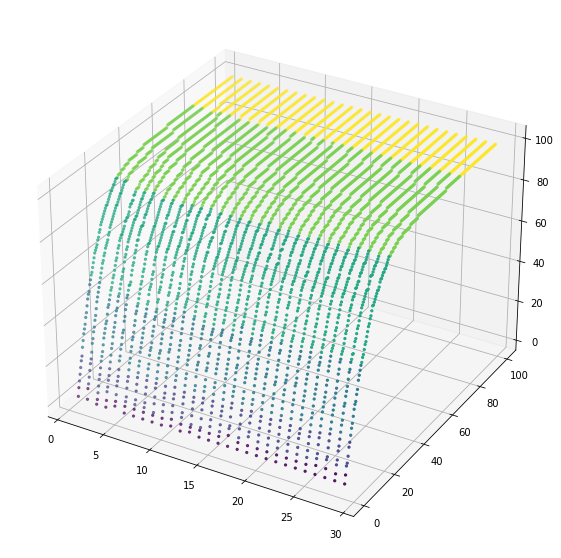

In [122]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdataset1, newdataset2, newdataset3, s=5, c = col)
plt.show()

In [119]:
col = np.arange(5771)
for i in range(0,5771) :
    col[i] = np.log((col[i]%199) +1)
col

array([0, 0, 1, ..., 5, 5, 5])